In [11]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 
import matplotlib.gridspec as gridspec
# from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [12]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [604]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, method):
    
    fa = factanal(df, factors=NUM, scores='regression', rotation=rotation, 
                  verbose=True, return_dict=True)
    
#     fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
#     fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/map_4_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left

    df_scores.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.53, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();

    fig.tight_layout()
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
    print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
    print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times, NUM, rotation, stations, gdf, weekend_removed, STATIONS_TO_DROP, show_factors):

    mpl.style.use('default')
    print(test_if_FA_suitable(df))
    
    # scree plot
    fa = FactorAnalyzer()
    fa.fit(df)
    ev, _ = fa.get_eigenvalues()
    scree_plot(ev,df)
    
    df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
    print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    
    col_names = df.columns
    loadings_plot(Loadings, col_names)
    
    # plot stations  
    # ascribe a factor to each station based on max loading value (and show it on map)
    stations = stations[stations.name.isin(df.columns)]
    stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
    stations['max_load'] = np.max(abs(Loadings),axis=1)
    plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
        print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())

    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed=weekend_removed)
    
    return Loadings, scores, stations.name


In [680]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
    df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    
    df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
#     stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
    stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,stations,gdf

In [684]:
# initialize to get times:
df,times,stations,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# extreme events/only the dust storm
pm_threshold = 100

# remove dust storms in 2015 and 100
time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))) 
#                   | ((df > pm_threshold).all(axis=1))
                 ]

idx_to_drop = np.argwhere(time_condition)[:,1]
df.drop(idx_to_drop,axis = 0, inplace=True)
times.drop(idx_to_drop,axis = 0, inplace=True)

# remove stations
STATIONS_TO_DROP = []
# STATIONS_TO_DROP = ['AFULA', 'KVISH4',
#        'YEFET_YAFO', 'KIRYAT_ATA', 'KIRYAT_BIALIK',  'NESHER', 'BAR_ILAN',
#        'EFRATA',  'ASHKELON_SOUTH', 'GEDERA',
#        'KIRYAT_MALAHI', 'ORT', 'ROVA_TV', 
#        'YAHALOM', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']
# STATIONS_TO_DROP = ['BAR_ILAN','ATZMAUT_B','KIRYAT_BINYAMIN','KFAR_MASARIK','KIRYAT_TIVON','IRONID','KVISH4','REMEZ','YEFET_YAFO','RAANANA','EAST_NEGEV','EFRATA','AFULA','PARDES_HANA','BEER_SHEVA']
# traffic stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','BAR_ILAN','RAANANA']
# distant stations:
# STATIONS_TO_DROP = ['BAR_ILAN','EAST_NEGEV','EFRATA','AFULA','PARDES_HANA','BEER_SHEVA']


# # ONLY SOUTH
# STATIONS_TO_DROP = ['BAR_ILAN','AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'EFRATA',
#        'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA','BEER_SHEVA'] 

# # ONLY NORTH
# STATIONS_TO_DROP = ['BAR_ILAN','ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO','EFRATA','ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
#        'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA']#,'ATZMAUT_B','AFULA']

# # ONLY CENTER
# STATIONS_TO_DROP = ['AFULA', 'ANTOKOLSKY', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN',
#        'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM',
#        'KIRYAT_MALAHI', 'NIR_ISRAEL', 'SDEROT', 'SDE_YOAV',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']# 'ORT', 'ROVA_TV'

df.drop(STATIONS_TO_DROP,axis=1,inplace=True)

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [682]:
df.columns

Index(['AFULA', 'ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ',
       'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
       'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN',
       'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
       'RAANANA'],
      dtype='object')

In [683]:
# save as csv to R
df.to_csv('/tmp/df.csv', index=False)
times.to_csv('/tmp/times.csv', index=False)

## RUN FA IN R

In [691]:
df_load = pd.read_csv('/tmp/loadings.csv')

column_names = df_load['Unnamed: 0'].values

df_load.drop(columns = 'Unnamed: 0',inplace=True)

df_scores = pd.read_csv('/tmp/scores.csv')
df_scores.drop(columns = 'Unnamed: 0',inplace=True)

In [694]:
# unstandardized
# df_uns_scores = pd.read_csv('/tmp/unstandardizedScores.csv')
# df_uns_scores.drop(columns = 'Unnamed: 0',inplace=True)

In [764]:
# higher order
df_load = pd.read_csv('/tmp/loadingsHO.csv')

column_names = df_load['Unnamed: 0'].values

df_load.drop(columns = 'Unnamed: 0',inplace=True)

df_scores = pd.read_csv('/tmp/scoresHO.csv')
df_scores.drop(columns = 'Unnamed: 0',inplace=True)

In [765]:
# df_scores.ML1 = - df_scores.ML1
# df_load.ML1 = - df_load.ML1

# df_scores.ML2 = - df_scores.ML2
# df_load.ML2 = - df_load.ML2

In [766]:
NUM = 2
weekend_removed = False

In [767]:
# df_scores.Factor3 = - df_scores.Factor3 
# df_load.Factor3 = - df_load.Factor3

In [768]:
# df_scores.Factor2 = - df_scores.Factor2 
# df_load.Factor2 = - df_load.Factor2

In [769]:
# df_scores.Factor1 = - df_scores.Factor1
# df_load.Factor1 = - df_load.Factor1

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


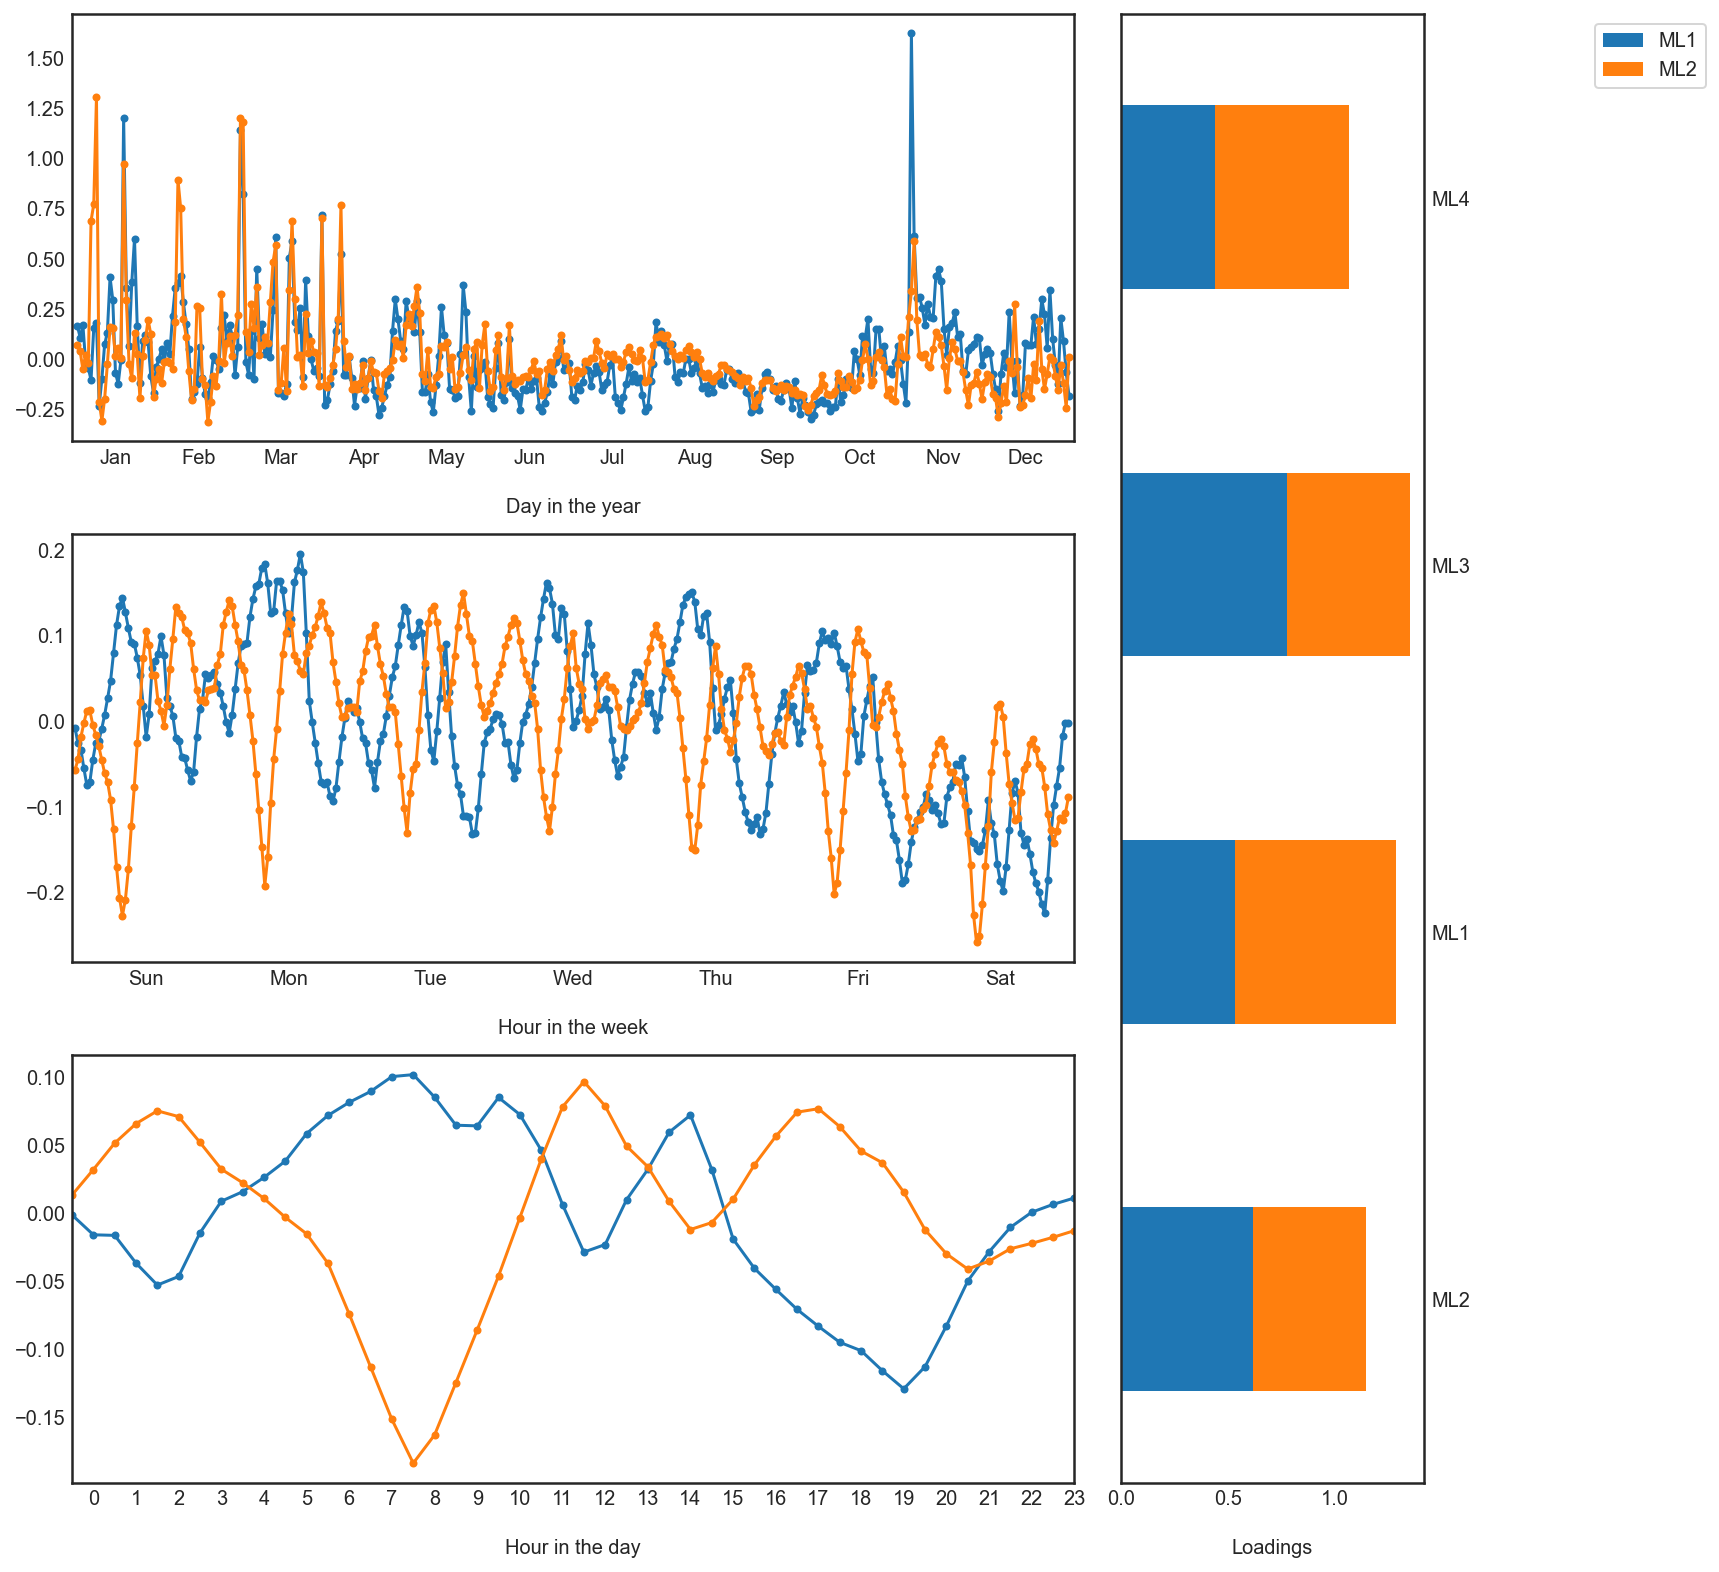

In [770]:
# list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]
# list_of_factors = ['scores.ML'+str(i+1) for i in range(NUM)]
list_of_factors = ['ML'+str(i+1) for i in range(NUM)]

# df_load = pd.DataFrameFrame(Loadings,columns=list_of_factors)
# df_scores = pd.DataFrame(scores, columns=list_of_factors)
df_scores = add_group_columns_to_df_scores(df_scores,times)

plot_factors_and_loadings(df_scores,df_load, list_of_factors, column_names, weekend_removed=weekend_removed)

In [ ]:
# maybe try to do ICA on each of the factors. maybe the high values in the night might be due to atmospheric stability
# and the the minima in the middle of the day due to wind... or max radiation. 

### Independent Component Analysis (ICA) - has the same problem of switching the order of the factors as was with python's FA

In [639]:
NUM = 3
weekend_removed = False
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [640]:
# Compute ICA
ica = FastICA(n_components=NUM, random_state=10)
S_ = ica.fit_transform(df)  # FACTORS (=extracted signals)
A_ = ica.mixing_  # LOADINGS (mixing matrix)
S_.shape
A_.shape

(139824, 3)

(15, 3)

In [641]:
column_names = df.columns

In [642]:
A_
S_

array([[ 4775.47674837, -1841.79051353,  2633.36925805],
       [ 4339.77718906, -1435.04058914,  2453.68351844],
       [ 5080.87111395, -1357.39770368,  3088.61295333],
       [ 7787.24560477,  -884.93731404,  2068.21922246],
       [ 1793.87593054, -1464.00574525,  4413.8287787 ],
       [ 1668.28134641,  -567.49045631,  3577.66019297],
       [ 1346.25435587,  -766.51242375,  4743.85370323],
       [ 1324.87364114, -1197.34225043,  4742.70094303],
       [ 1431.83439015,  -988.05279635,  3890.7647782 ],
       [ 3831.04921171, -3260.34790293,  2802.84054263],
       [ 3860.04661627, -5741.05989583,  2415.69554296],
       [ 4092.47378555, -4851.90004318,  2474.22652386],
       [ 3323.9054726 , -5842.28503362,  2940.46657406],
       [ 3697.4647869 , -5964.5390597 ,  3175.48676528],
       [ 3704.63381735, -3928.36756759,  1676.94826055]])

array([[-2.17845964e-04,  4.89944579e-04, -3.18989330e-04],
       [-8.01351144e-04,  5.33759991e-04,  4.57516195e-04],
       [-9.36542188e-04,  7.27072436e-04,  6.57428894e-04],
       ...,
       [-7.05373464e-05, -2.12676824e-04,  5.99459184e-05],
       [ 6.81470277e-04,  1.28532265e-03,  2.28008018e-04],
       [ 2.53235235e-04,  3.35139201e-04, -9.49954057e-05]])

In [650]:
col_to_flip = 1
A_[:,col_to_flip]=-A_[:,col_to_flip]
S_[:,col_to_flip]=-S_[:,col_to_flip]

In [652]:
# http://www.brainvoyager.com/ubb/Forum4/HTML/000613.html
# https://www.researchgate.net/post/What_does_negativity_mean_in_the_unmixed_components_in_Independent_Component_Analysis_ICA

In [653]:
df_load = pd.DataFrame(A_,columns=list_of_factors)
df_scores = pd.DataFrame(S_, columns=list_of_factors)

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


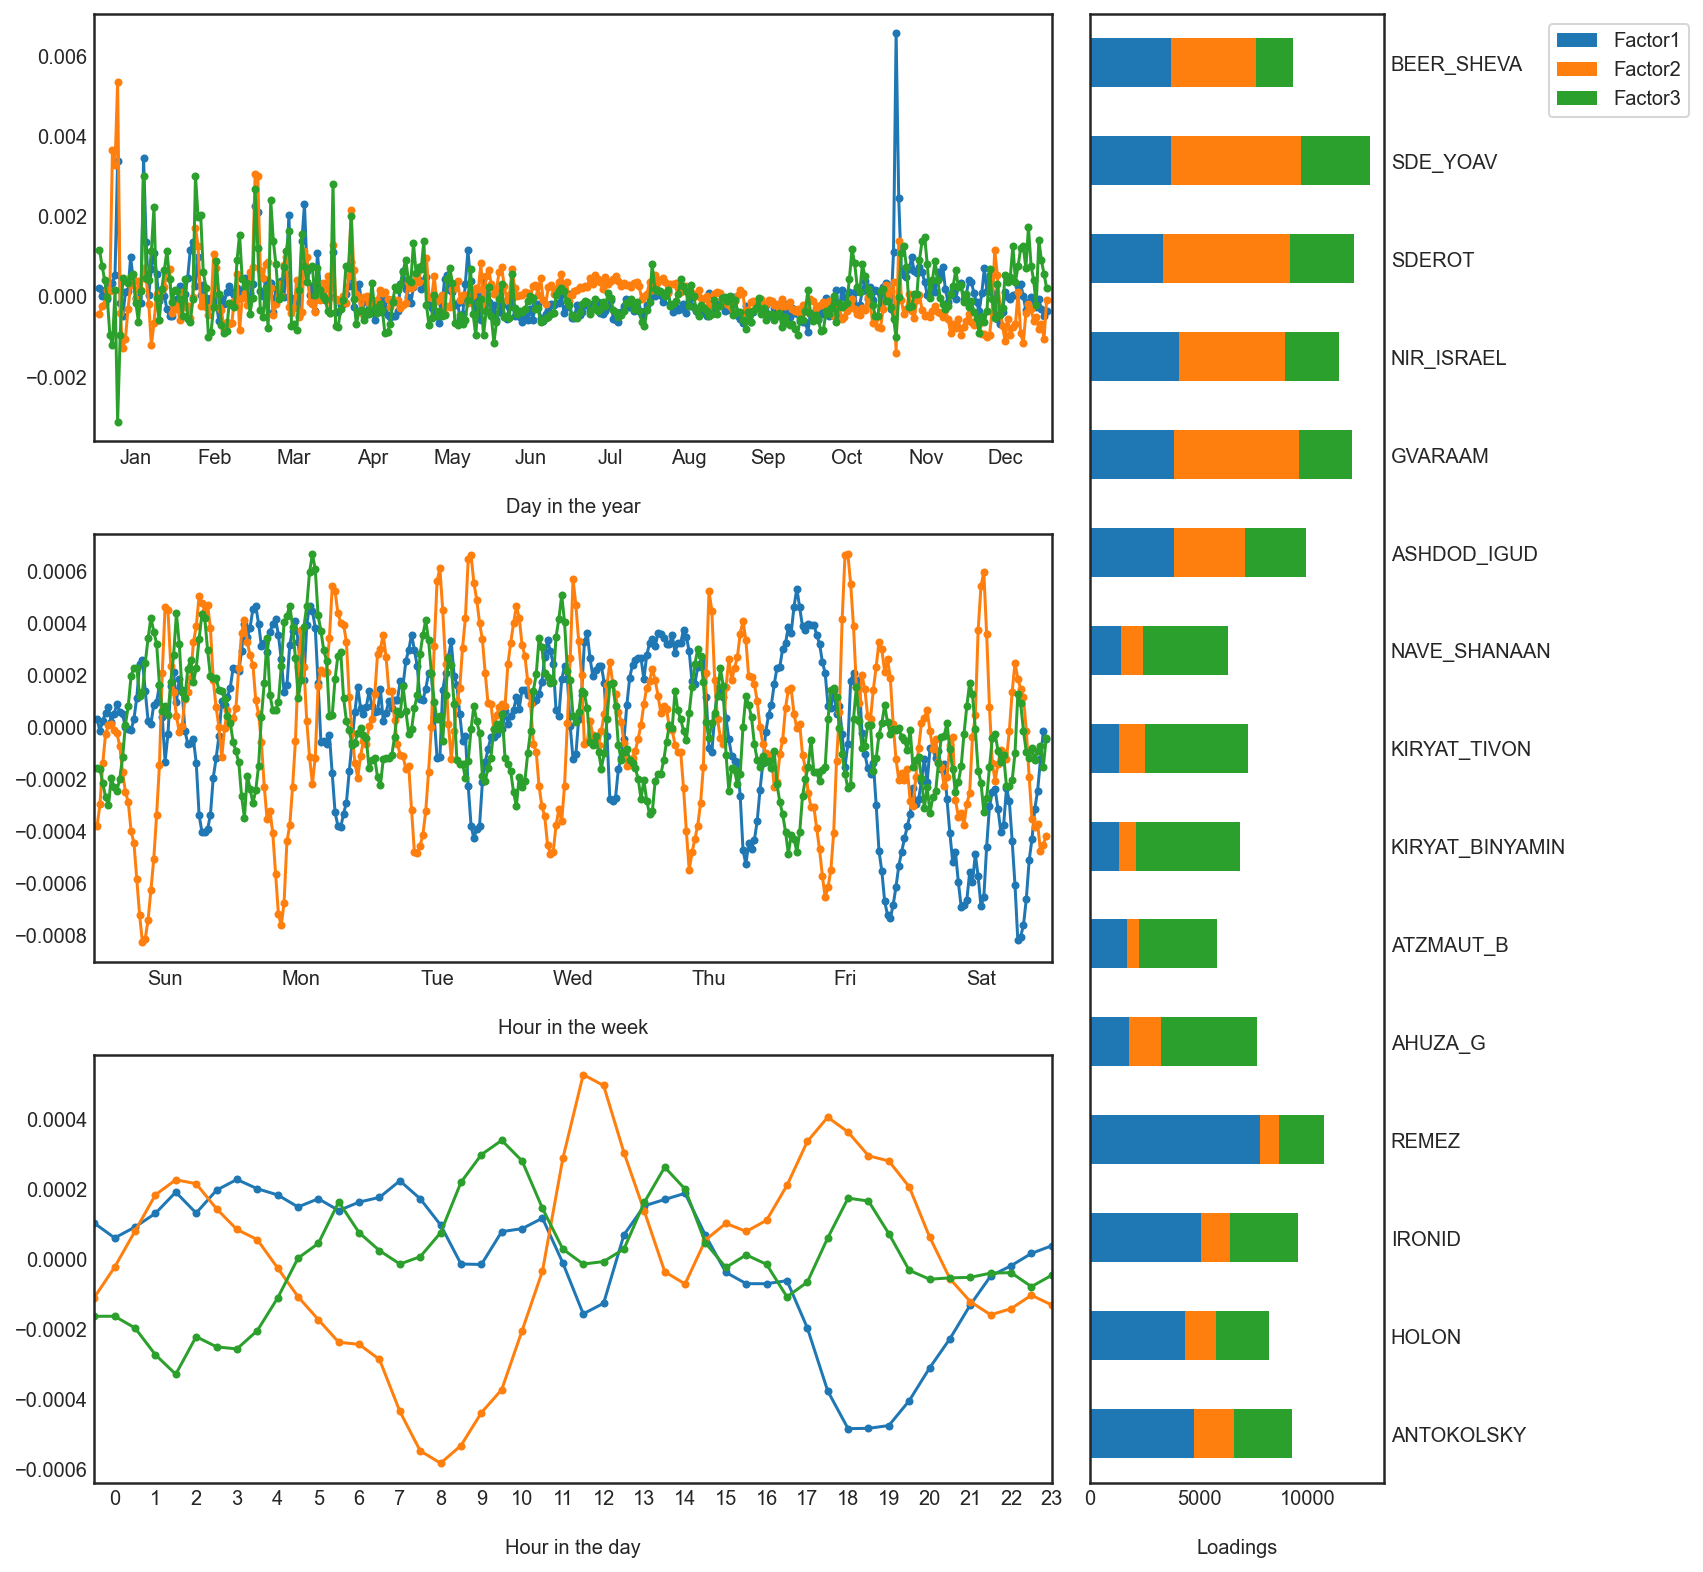

In [654]:
df_scores = add_group_columns_to_df_scores(df_scores,times)
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed=weekend_removed)

In [223]:
#NMF
from sklearn.decomposition import non_negative_factorization, NMF

In [236]:
NUM = 4
weekend_removed = False
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [237]:
W, H, n_iter = non_negative_factorization(df, n_components=NUM, init='random', random_state=0, max_iter=1000)
W.shape
H.shape

(135779, 4)

(4, 32)

In [238]:
# model = NMF(n_components=NUM, init='random', random_state=0, max_iter=1000)
# W = model.fit_transform(df)
# H = model.components_

In [239]:
column_names = df.columns

In [240]:
df_load = pd.DataFrame(H.T,columns=list_of_factors)
df_scores = pd.DataFrame(W, columns=list_of_factors)

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


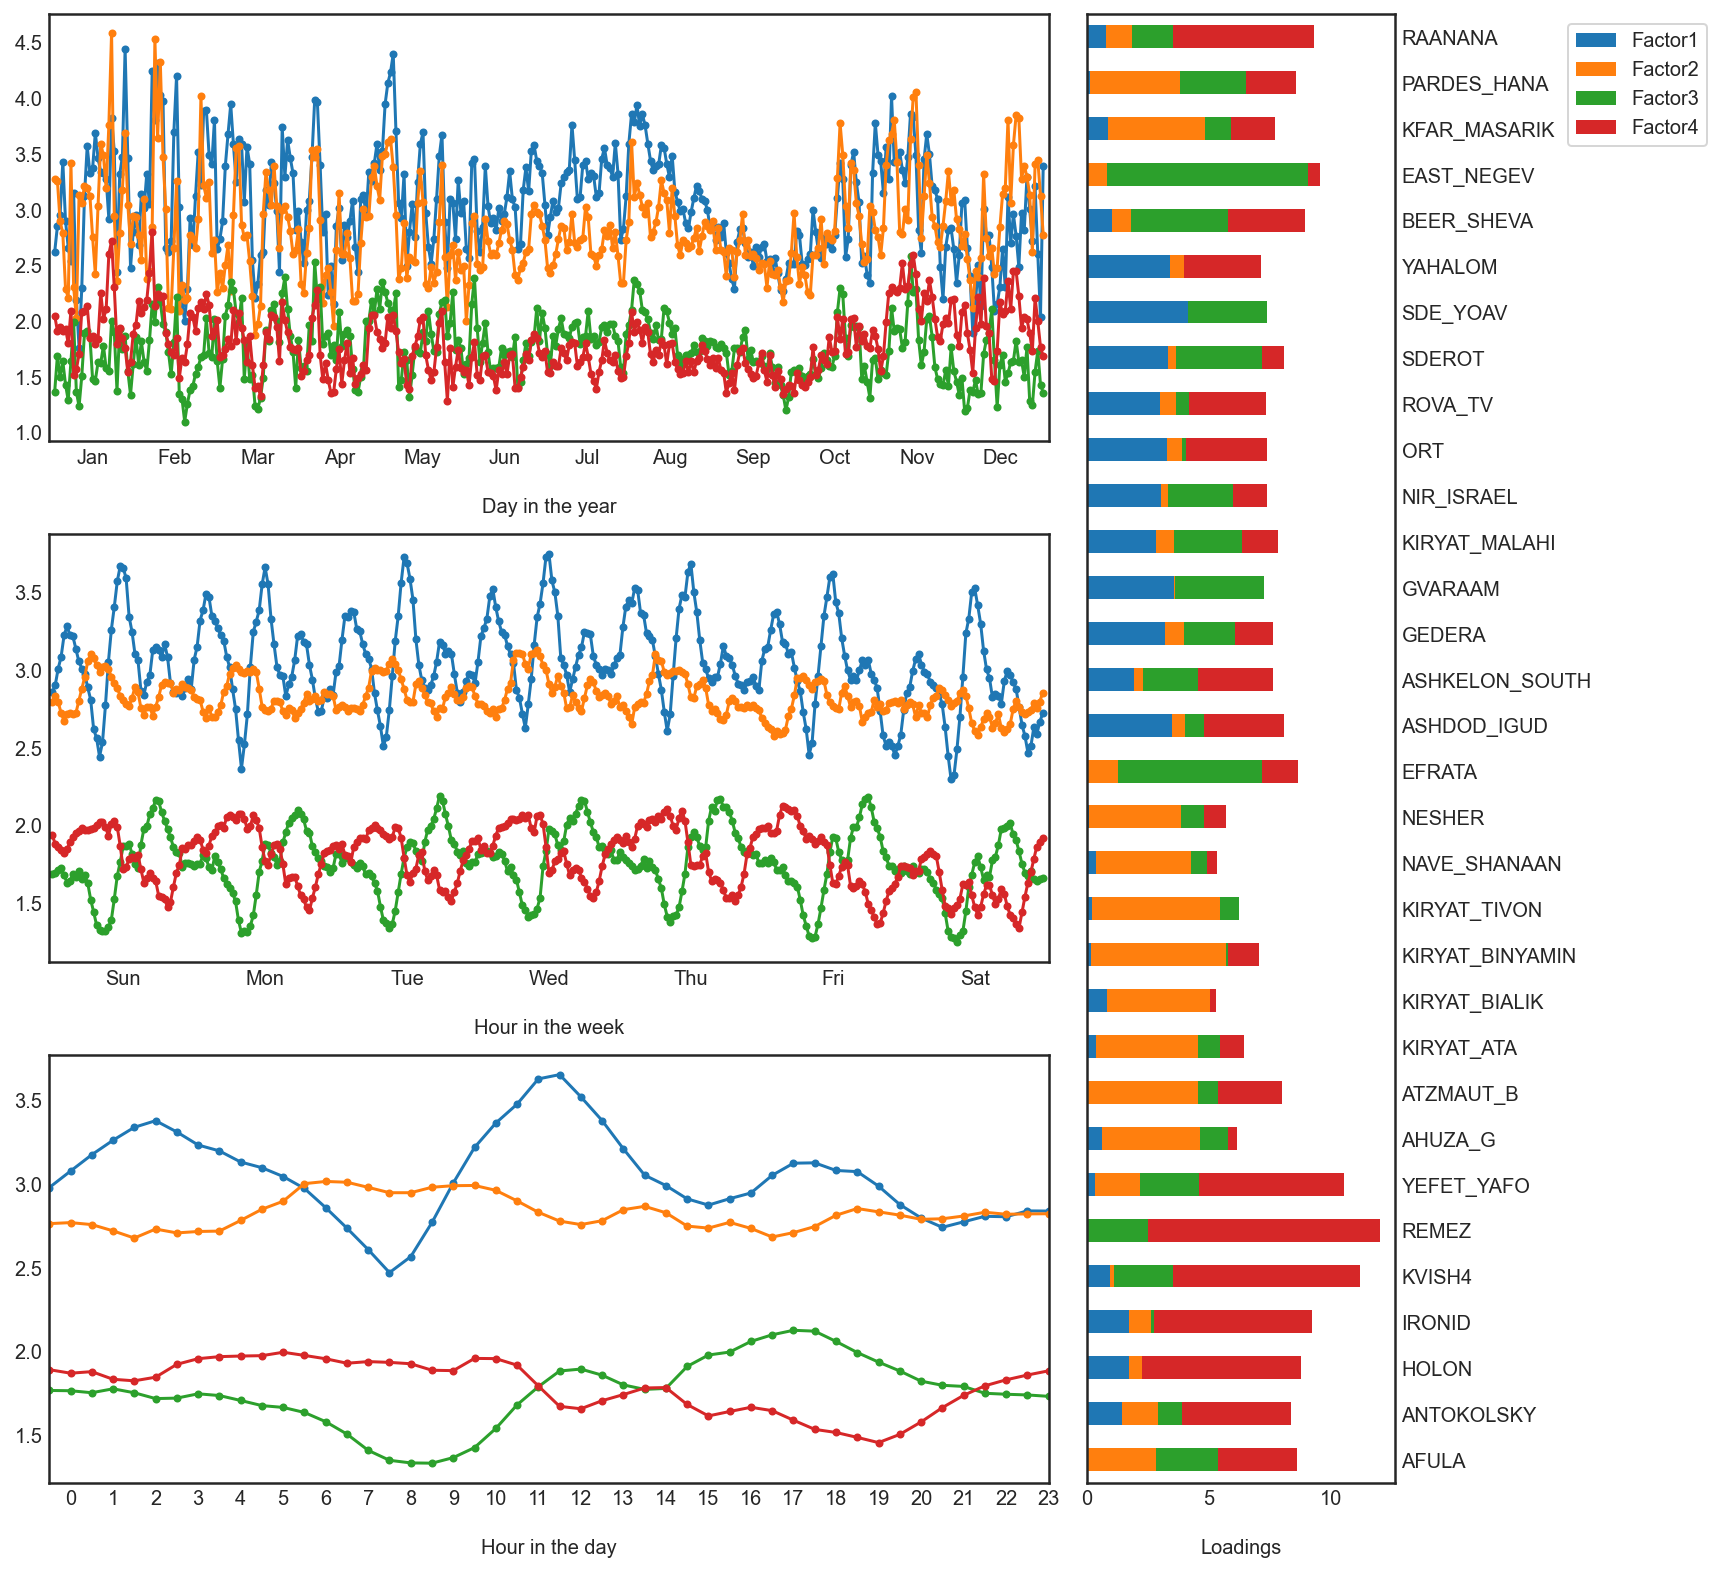

In [241]:
df_scores = add_group_columns_to_df_scores(df_scores,times)

plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed=weekend_removed)